BloomTech Data Science

*Unit 2, Sprint 1, Module 3*

---

# Module Project: Ridge Regression

For this project, you'll return to the Tribecca Condo dataset. But this time, you'll look at the _entire_ dataset and try to predict property sale prices.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

## Directions

The tasks for this project are the following:

- **Task 1:** Import `csv` file using `wrangle` function.
- **Task 2:** Conduct exploratory data analysis (EDA), and modify `wrangle` function to engineer two subset your dataset to one-family dwellings whose price is between \\$100,000 and \\$2,000,000.
- **Task 3:** Split data into feature matrix `X` and target vector `y`.
- **Task 4:** Split feature matrix `X` and target vector `y` into training and test sets.
- **Task 5:** Establish the baseline mean absolute error for your dataset.
- **Task 6:** Build and train a `OneHotEncoder`, and transform `X_train` and `X_test`.
- **Task 7:** Build and train a `LinearRegression` model.
- **Task 8:** Build and train a `Ridge` model.
- **Task 9:** Calculate the training and test mean absolute error for your `LinearRegression` model.
- **Task 10:** Calculate the training and test mean absolute error for your `Ridge` model.
- **Task 11:** Create a horizontal bar chart showing the 10 most influencial features for your `Ridge` model.

**Note**

You should limit yourself to the following libraries for this project:

- `category_encoders`
- `matplotlib`
- `pandas`
- `sklearn`

# I. Wrangle Data

In [50]:
!pip install category_encoders

In [51]:
# Model Building

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

# for encoding categorical data
from category_encoders import OneHotEncoder

In [52]:
def wrangle(filepath):
    # Import csv file
    cols = ['BOROUGH', 'NEIGHBORHOOD',
            'BUILDING CLASS CATEGORY', 'GROSS SQUARE FEET',
            'YEAR BUILT', 'SALE PRICE', 'SALE DATE']

    df = pd.read_csv(filepath,
                     usecols=cols,
                     parse_dates=['SALE DATE'],
                     index_col='SALE DATE',
                     dtype={'BOROUGH':'object'})

    # Clean col headers
    df.columns = df.columns.str.lower().str.replace(' ', '_')

    df['sale_price'] = df['sale_price'].str.replace('$', '', regex=False).str.replace(',', '', regex=False).str.replace('-', '', regex=False).str.strip()
    df['sale_price'] = pd.to_numeric(df['sale_price'], errors='coerce').fillna(0).astype(int)

    # dataset only includes one-family dwellings
    # The dataset includes only properties whose sale price is between \$100,000 and \$2,000,000.
    df = df[(df['building_class_category'] == '01 ONE FAMILY DWELLINGS') &
            (df['sale_price'] > 100_000) &
            (df['sale_price'] < 2_000_000)]

    return df.drop(columns='building_class_category')

filepath = "https://raw.githubusercontent.com/bloominstituteoftechnology/DS-Unit-2-Linear-Models/master/data/condos/NYC_Citywide_Rolling_Calendar_Sales.csv"

**Task 1:** Use the above `wrangle` function to import the `NYC_Citywide_Rolling_Calendar_Sales.csv` file into a DataFrame named `df`.

In [53]:
df = wrangle(filepath)

**Task 2:** Modify the above `wrangle` function so that:

- The column `'SALE DATE'` becomes the `DatetimeIndex`.
- The dtype for the `'BOROUGH'` column is `object`, not `int`.
- The dtype for the `'SALE PRICE'` column is `int`, not `object`.
- The dataset includes only one-family dwellings (`BUILDING CLASS CATEGORY == '01 ONE FAMILY DWELLINGS'`).
- The dataset includes only properties whose sale price is between \\$100,000 and \\$2,000,000.

In [54]:
# Perform your exploratory data analysis here and
# modify the wrangle function above
df.head()

,borough,neighborhood,gross_square_feet,year_built,sale_price
SALE DATE,,,,,
2019-01-01,3,OCEAN PARKWAY-NORTH,1325.0,1930.0,550000
2019-01-01,4,QUEENS VILLAGE,2001.0,1940.0,200000
2019-01-02,2,PELHAM PARKWAY SOUTH,2043.0,1925.0,810000
2019-01-02,3,FLATBUSH-CENTRAL,2680.0,1899.0,125000
2019-01-02,3,FLATBUSH-EAST,1872.0,1940.0,620000


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3151 entries, 2019-01-01 to 2019-04-30
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   borough            3151 non-null   object 
 1   neighborhood       3151 non-null   object 
 2   gross_square_feet  3151 non-null   float64
 3   year_built         3151 non-null   float64
 4   sale_price         3151 non-null   int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 147.7+ KB


In [56]:
df.isnull().sum()

,0
borough,0
neighborhood,0
gross_square_feet,0
year_built,0
sale_price,0


# II. Split Data

**Task 3:** Split your dataset into the feature matrix `X` and the target vector `y`. You want to predict `'SALE_PRICE'`.

In [57]:
target = 'sale_price'
y = df[target]
X = df.drop(columns=target)

In [58]:
X.index.max(), X.index.min()

(Timestamp('2019-04-30 00:00:00'), Timestamp('2019-01-01 00:00:00'))

**Task 4:** Split `X` and `y` into a training set (`X_train`, `y_train`) and a test set (`X_test`, `y_test`).

- Your training set should include data from January to March 2019.
- Your test set should include data from April 2019.

In [59]:
cutoff = '2019-04-01'

mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [60]:
X_train.shape, y_train.shape

((2507, 4), (2507,))

In [61]:
X_test.shape, y_test.shape

((644, 4), (644,))

# III. Establish Baseline

**Task 5:** Since this is a **regression** problem, you need to calculate the baseline mean absolute error for your model.

In [62]:
y_pred = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred)
print('Mean price:', y_train.mean())
print('Baseline MAE:', baseline_mae)

Mean price: 621573.7423214999
Baseline MAE: 214721.52773001452


# IV. Build Model

**Task 6:** Build and train a `OneHotEncoder` and then use it to transform `X_train` and `X_test`.

In [63]:
ohe = OneHotEncoder(use_cat_names=True)

ohe.fit(X_train)

XT_train = ohe.transform(X_train)
XT_test = ohe.transform(X_test)

In [64]:
XT_train.head(2)

,borough_3,borough_4,borough_2,borough_5,borough_1,neighborhood_OCEAN PARKWAY-NORTH,neighborhood_QUEENS VILLAGE,neighborhood_PELHAM PARKWAY SOUTH,neighborhood_FLATBUSH-CENTRAL,neighborhood_FLATBUSH-EAST,neighborhood_MADISON,neighborhood_MIDWOOD,neighborhood_BAYSIDE,neighborhood_ELMHURST,neighborhood_FLUSHING-NORTH,neighborhood_HOLLIS,neighborhood_HOWARD BEACH,neighborhood_JACKSON HEIGHTS,neighborhood_KEW GARDENS,neighborhood_LAURELTON,neighborhood_SO. JAMAICA-BAISLEY PARK,neighborhood_SOUTH JAMAICA,neighborhood_SPRINGFIELD GARDENS,neighborhood_ELTINGVILLE,neighborhood_GREAT KILLS,neighborhood_MANOR HEIGHTS,neighborhood_WESTERLEIGH,neighborhood_CANARSIE,neighborhood_DYKER HEIGHTS,neighborhood_EAST NEW YORK,neighborhood_GERRITSEN BEACH,neighborhood_OLD MILL BASIN,neighborhood_CAMBRIA HEIGHTS,neighborhood_CORONA,neighborhood_DOUGLASTON,neighborhood_FAR ROCKAWAY,neighborhood_FLUSHING-SOUTH,neighborhood_FRESH MEADOWS,neighborhood_HOLLISWOOD,neighborhood_JAMAICA,...,neighborhood_CONEY ISLAND,neighborhood_MILL BASIN,neighborhood_KINGSBRIDGE HTS/UNIV HTS,neighborhood_SUNSET PARK,neighborhood_GRYMES HILL,neighborhood_NEW DORP,neighborhood_STAPLETON,neighborhood_PARK SLOPE SOUTH,neighborhood_LIVINGSTON,neighborhood_TOMPKINSVILLE,neighborhood_CITY ISLAND,neighborhood_GLEN OAKS,neighborhood_NEPONSIT,neighborhood_DONGAN HILLS,neighborhood_STAPLETON-CLIFTON,neighborhood_ARVERNE,neighborhood_FLATBUSH-LEFFERTS GARDEN,neighborhood_BELLE HARBOR,neighborhood_EMERSON HILL,neighborhood_BATH BEACH,neighborhood_HILLCREST,neighborhood_OCEAN HILL,neighborhood_MORRISANIA/LONGWOOD,neighborhood_CLINTON HILL,neighborhood_ARROCHAR,neighborhood_TRAVIS,neighborhood_BUSHWICK,neighborhood_HOLLIS HILLS,neighborhood_BROAD CHANNEL,neighborhood_INWOOD,neighborhood_CROTONA PARK,neighborhood_BATHGATE,neighborhood_ROSSVILLE-RICHMOND VALLEY,neighborhood_BELMONT,neighborhood_MOUNT HOPE/MOUNT EDEN,neighborhood_PARKCHESTER,neighborhood_DONGAN HILLS-OLD TOWN,neighborhood_FIELDSTON,gross_square_feet,year_built
SALE DATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1325.0,1930.0
2019-01-01,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2001.0,1940.0


**Task 7:** Build and train a `LinearRegression` model named `model_lr`. Remember to train your model using your _transformed_ feature matrix.

In [65]:
model_lr = LinearRegression()
model_lr.fit(XT_train, y_train)

LinearRegression()

**Task 8:** Build and train a `Ridge` model named `model_r`. Remember to train your model using your _transformed_ feature matrix.

In [66]:
model_r = Ridge(alpha=1.0)
model_r.fit(XT_train, y_train)

Ridge()

# V. Check Metrics

**Task 9:** Check the training and test metrics for `model_lr`.

In [67]:
training_mae_lr = mean_absolute_error(y_train, model_lr.predict(XT_train))
test_mae_lr = mean_absolute_error(y_test, model_lr.predict(XT_test))

print('Linear Training MAE:', training_mae_lr)
print('Linear Test MAE:', test_mae_lr)

Linear Training MAE: 124775.58464638109
Linear Test MAE: 140504.0589913885


**Task 10:** Check the training and test metrics for `model_r`.

In [68]:
training_mae_r = mean_absolute_error(y_train, model_r.predict(XT_train))
test_mae_r = mean_absolute_error(y_test, model_r.predict(XT_test))

print('Ridge Training MAE:', training_mae_r)
print('Ridge Test MAE:', test_mae_r)

Ridge Training MAE: 126035.03017055118
Ridge Test MAE: 138773.29519519108


**Stretch Goal:** Calculate the training and test $R^2$ scores `model_r`.

In [69]:
# Calculate R^2 score
training_r2_r = model_r.score(XT_train, y_train)
test_r2_r = model_r.score(XT_test, y_test)

print('Ridge Training R^2:', training_r2_r)
print('Ridge Test R^2:', test_r2_r)

Ridge Training R^2: 0.6184461662522489
Ridge Test R^2: 0.4879994292970723


# IV. Communicate Results

**Task 11:** Create a horizontal barchart that plots the 10 most important coefficients for `model_r`, sorted by absolute value. Your figure should look like our example from class:

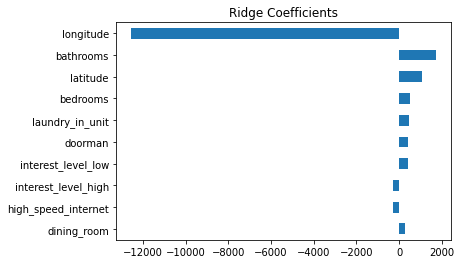

**Note:** Your figure shouldn't be identical to the one above. Your model will have different coefficients since it's been trained on different data. Only the formatting should be the same.

Text(0.5, 1.0, 'Coefficients for Ridge Regression')

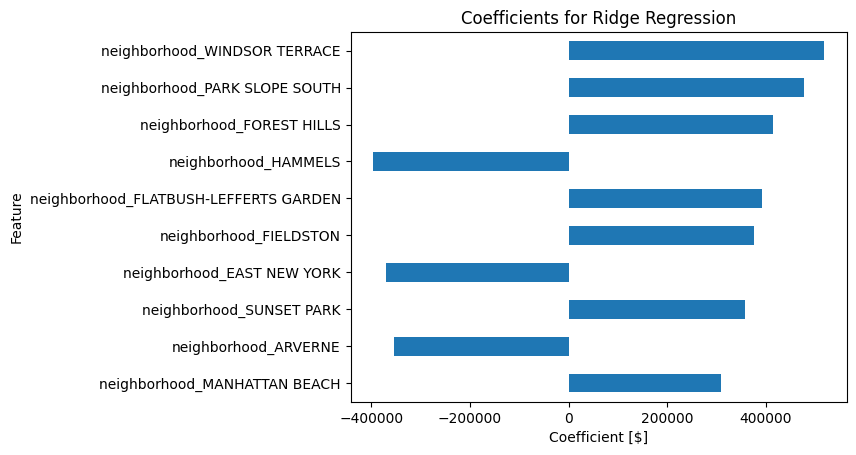

In [70]:
coefficients = model_r.coef_
features = ohe.get_feature_names_out()

feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
# feat_imp
feat_imp.tail(10).plot(kind='barh')

plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression')